<a href="https://colab.research.google.com/github/davdavDTB/WeightsWatchers/blob/master/SVM_FashionMNIST_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
This code is work in progress

SVM on FashionMNIST, uses PCA for feature extraction

Evaluation not done yet (although you can check accuracy)

David
"""

'\nThis code is work in progress\n\nSVM on FashionMNIST, uses PCA for feature extraction\n\nEvaluation not done yet (although you can check accuracy)\n\nDavid\n'

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV

"""
from skimage.feature import hog
from skimage import color

import cv2
"""
from sklearn.metrics import classification_report

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# Load the fashion-mnist pre-shuffled train data and test data
(x_train, l_train), (x_test, l_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", l_train.shape)

32768/29515 [=================================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [0]:
#For HOG, experimenting

"""
def deskew(img, imgSize):
    # calculate image moments
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed
        return img.copy()

    # calculate skew based on central moments
    skew = m['mu11'] / m['mu02']

    # calculate affine transformation to correct skewness
    M = np.float32([[1, skew, -0.5*imgSize*skew], [0, 1, 0]])

    # apply affine transformation
    img = cv2.warpAffine(img, M, (imgSize, imgSize), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

    return img
"""

"\ndef deskew(img, imgSize):\n    # calculate image moments\n    m = cv2.moments(img)\n    if abs(m['mu02']) < 1e-2:\n        # no deskewing needed\n        return img.copy()\n\n    # calculate skew based on central moments\n    skew = m['mu11'] / m['mu02']\n\n    # calculate affine transformation to correct skewness\n    M = np.float32([[1, skew, -0.5*imgSize*skew], [0, 1, 0]])\n\n    # apply affine transformation\n    img = cv2.warpAffine(img, M, (imgSize, imgSize), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)\n\n    return img\n"

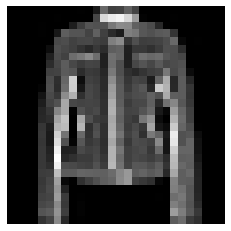

Target: Coat


In [0]:
#Just showing the data

fashion_classes     = {0: 'T-shirt/top', 
                       1: 'Trouser', 
                       2: 'Pullover', 
                       3: 'Dress', 
                       4: 'Coat',
                       5: 'Sandal', 
                       6: 'Shirt', 
                       7: 'Sneaker', 
                       8: 'Bag', 
                       9: 'Ankle boot'}

mnist_classes       = [i for i in range(10)]
num_classes         = 10

idx = np.random.randint(len(x_train))
plt.imshow(np.squeeze(x_train[idx]), cmap='gray')
plt.axis('off')
plt.show()

print("Target:", fashion_classes[l_train[idx]])

In [0]:
#Flattening train images
x_train = np.reshape(x_train, (60000, 784))
print(x_train)
print(l_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[9 0 0 ... 3 0 5]


In [0]:
#Flattening test images
x_test = np.reshape(x_test, (10000, 784))
print(x_test)
print(l_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[9 2 1 ... 8 1 5]


In [0]:
#Principle Component Analysis
pca = PCA(n_components=200) #code lasts 1min when n_components=20
pca.fit(x_train)
i_train = pca.transform(x_train)
i_test = pca.transform(x_test)

In [0]:
"""
#HOG

imsize = 28 # size of image (28x28)

# HOG parameters:
winSize = (imsize, imsize) # 28, 28
blockSize = (imsize//2, imsize//2) # 14, 14    
cellSize = (imsize//2, imsize//2) #14, 14
blockStride = (imsize//4, imsize//4) # 7, 7
nbins = 9
signedGradients = True
derivAperture = 1
winSigma = -1.0
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64

# define the HOG descriptor
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, 
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels, signedGradients) #visualization=True

"""

'\n#HOG\n\nimsize = 28 # size of image (28x28)\n\n# HOG parameters:\nwinSize = (imsize, imsize) # 28, 28\nblockSize = (imsize//2, imsize//2) # 14, 14    \ncellSize = (imsize//2, imsize//2) #14, 14\nblockStride = (imsize//4, imsize//4) # 7, 7\nnbins = 9\nsignedGradients = True\nderivAperture = 1\nwinSigma = -1.0\nhistogramNormType = 0\nL2HysThreshold = 0.2\ngammaCorrection = 1\nnlevels = 64\n\n# define the HOG descriptor\nhog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, \n                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels, signedGradients) #visualization=True\n\n'

In [0]:
"""
# compute HOG descriptors
train_descriptors = []
for i in range(i_train.shape[0]):
    #i_train[i] = deskew(i_train[i], 28) # deskew the current image
    descriptor = hog.compute(i_train[i]) # compute the HOG features
    train_descriptors.append(descriptor) # append it to the train decriptors list

test_descriptors = []
for i in range(i_test.shape[0]):
    #i_test[i] = deskew(i_test[i], 28) # deskew the current image
    descriptor = hog.compute(i_test[i]) # compute the HOG features
    test_descriptors.append(descriptor) # append it to the test descriptors list

#train_descriptors = np.array(train_descriptors)
train_descriptors = np.resize(train_descriptors, (i_train.shape[0], 81))

#test_descriptors = np.array(test_descriptors)
test_descriptors = np.resize(test_descriptors, (i_test.shape[0], 81))
"""

'\n# compute HOG descriptors\ntrain_descriptors = []\nfor i in range(i_train.shape[0]):\n    #i_train[i] = deskew(i_train[i], 28) # deskew the current image\n    descriptor = hog.compute(i_train[i]) # compute the HOG features\n    train_descriptors.append(descriptor) # append it to the train decriptors list\n\ntest_descriptors = []\nfor i in range(i_test.shape[0]):\n    #i_test[i] = deskew(i_test[i], 28) # deskew the current image\n    descriptor = hog.compute(i_test[i]) # compute the HOG features\n    test_descriptors.append(descriptor) # append it to the test descriptors list\n\n#train_descriptors = np.array(train_descriptors)\ntrain_descriptors = np.resize(train_descriptors, (i_train.shape[0], 81))\n\n#test_descriptors = np.array(test_descriptors)\ntest_descriptors = np.resize(test_descriptors, (i_test.shape[0], 81))\n'

In [0]:
#Defining classifier parameters and fitting train data
clf = svm.SVC(C = 100, kernel = 'rbf')
clf.fit(i_train, l_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
#Predictions on test data
predicted = clf.predict(i_test)
print(predicted)

[9 2 1 ... 8 1 5]


In [0]:
#Homemade result count and accuracy function
corrects = 0
false = 0


for i in range(0, len(l_test)):
    if predicted[i] == l_test[i]:
        corrects += 1
    else:
        false += 1

print(corrects)
print(false)

accuracy = corrects/len(l_test)
print(accuracy)
print(len(predicted))

9015
985
0.9015
10000


In [0]:
#metrics
acc = metrics.accuracy_score(l_test, predicted)

cmat = metrics.confusion_matrix(l_test, predicted)

prec = metrics.precision_score(l_test, predicted, average='weighted')
rec = metrics.recall_score(l_test, predicted, average='weighted')
f1 = metrics.f1_score(l_test, predicted, average='weighted')

print("accuracy =", acc*100, "%")
print("precision =", prec)
print("recall =", rec)
print("f1 =", f1)

print(classification_report(l_test, predicted))


accuracy = 90.14999999999999 %
precision = 0.9015157199381058
recall = 0.9015
f1 = 0.9013941489173855
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.80      0.85      0.83      1000
           3       0.91      0.90      0.91      1000
           4       0.84      0.83      0.84      1000
           5       0.98      0.97      0.97      1000
           6       0.75      0.72      0.74      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [0]:
#Lecture 7:
#set random state=42